Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Try other [scikit-learn scalers](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this problem, you may want to use the parameter `logistic=True`

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```



In [ ]:
'''
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')
'''

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [2]:
# Assign targets for investigation
target = 'status_group'

In [3]:
train.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

**Extraction Features Overview**

In [4]:
# Closer look at extraction features
extraction_information = ['extraction_type', 'extraction_type_group', 'extraction_type_class']
train[extraction_information].head(2)

,extraction_type,extraction_type_group,extraction_type_class
0,gravity,gravity,gravity
1,gravity,gravity,gravity


In [5]:
# It seems like two of the three can be dropped.  Check for most information via isnull().
# Investigate unique values in each
from IPython.display import display

display(train[extraction_information].isnull().sum(), train[extraction_information].describe())

extraction_type          0
extraction_type_group    0
extraction_type_class    0
dtype: int64

,extraction_type,extraction_type_group,extraction_type_class
count,59400,59400,59400
unique,18,13,7
top,gravity,gravity,gravity
freq,26780,26780,26780


In [6]:
# View unique elements in each extraction feature to see which to keep
for col in extraction_information:
    print('For col', col)
    display(train[col].unique())

For col extraction_type


array(['gravity', 'submersible', 'swn 80', 'nira/tanira', 'india mark ii',
       'other', 'ksb', 'mono', 'windmill', 'afridev', 'other - rope pump',
       'india mark iii', 'other - swn 81', 'other - play pump', 'cemo',
       'climax', 'walimi', 'other - mkulima/shinyanga'], dtype=object)

For col extraction_type_group


array(['gravity', 'submersible', 'swn 80', 'nira/tanira', 'india mark ii',
       'other', 'mono', 'wind-powered', 'afridev', 'rope pump',
       'india mark iii', 'other handpump', 'other motorpump'],
      dtype=object)

For col extraction_type_class


array(['gravity', 'submersible', 'handpump', 'other', 'motorpump',
       'wind-powered', 'rope pump'], dtype=object)

In [7]:
# Visualize extraction_type_group vs target
import matplotlib.pyplot as plt
import seaborn as sns

view = ['extraction_type_group'] + [target]
info_tab = pd.crosstab(train[view].extraction_type_group, train[view].status_group, normalize='index')
info_tab

status_group,functional,functional needs repair,non functional
extraction_type_group,,,
afridev,0.677966,0.023729,0.298305
gravity,0.599253,0.100859,0.299888
india mark ii,0.603333,0.032917,0.363750
india mark iii,0.448980,0.010204,0.540816
mono,0.377661,0.045026,0.577312
nira/tanira,0.664827,0.078612,0.256561
other,0.160031,0.032037,0.807932
other handpump,0.472527,0.054945,0.472527
other motorpump,0.434426,0.073770,0.491803


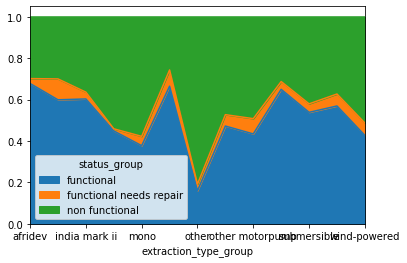

In [8]:
info_tab.plot(kind='area', stacked=True)

**Looking at latitude, longitude, and gps_height**

In [9]:
position_information = ['latitude', 'longitude', 'gps_height']
train[position_information].head(2)

,latitude,longitude,gps_height
0,-9.856322,34.938093,1390
1,-2.147466,34.698766,1399


In [10]:
train[position_information].describe()

,latitude,longitude,gps_height
count,5.940000e+04,59400.000000,59400.000000
mean,-5.706033e+00,34.077427,668.297239
std,2.946019e+00,6.567432,693.116350
min,-1.164944e+01,0.000000,-90.000000
25%,-8.540621e+00,33.090347,0.000000
50%,-5.021597e+00,34.908743,369.000000
75%,-3.326156e+00,37.178387,1319.250000
max,-2.000000e-08,40.345193,2770.000000


In [11]:
# It looks like zero (0) longitude is a nonsense or missing value placeholder.  
display(
    train[position_information][train.longitude == 0].head(2),
    train[position_information][train.longitude == 0].count(),
    train[position_information][train.latitude == -2.000000e-08].count(),
    train[position_information][train.gps_height == 0].count()
)

,latitude,longitude,gps_height
21,-2.000000e-08,0.0,0
53,-2.000000e-08,0.0,0


latitude      1812
longitude     1812
gps_height    1812
dtype: int64

latitude      1812
longitude     1812
gps_height    1812
dtype: int64

latitude      20438
longitude     20438
gps_height    20438
dtype: int64

**latitude and longitude have a significant number of missing values.  They will need to be captured and converted to NaN, then imputed or removed prior modeling**

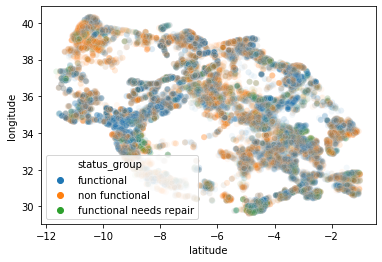

In [12]:
view = position_information + ['status_group']
view_select = (train[view].longitude != 0)
sns.scatterplot(x='latitude', y='longitude', hue='status_group', alpha=0.05,
                data=train[view_select])

**latitude/longitude do seem to have a significant impact. If clustering yields distinct areas that overlap above, we can replace the two coordinates with a cluster location.  I like this approach as the missing data will probably end up being a cluster of their own**


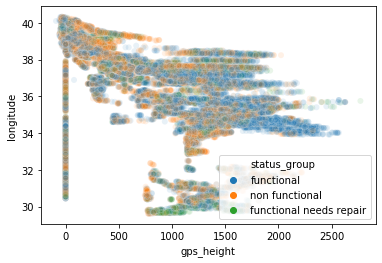

In [13]:
# Check if adding gps gives useful information
sns.scatterplot(x='gps_height', y='longitude', hue='status_group', alpha=0.1,
                data=train[view_select])

**It looks like gps is another good indicator. Consider clustering as well. Condensing the three spacial coordinates into defined clusters may also improve training speed for parameter evaluation downstream**

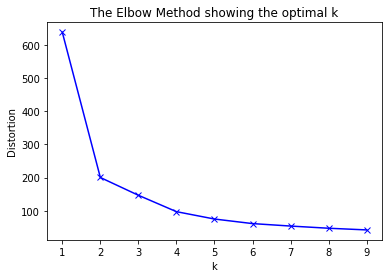

In [14]:
# k means clustering of 3-dimensional position:  determine k via elbow method
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np

X = train[view].drop(columns='status_group').to_numpy()

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

**At 4 clusters, we are nearing minimal improvement in distortion.  Will use 5 clusters to help improve granularity**
**We'll now build the position_transformer class to handle this transform**

Position Transform will:
* Fit KMeans clustering model with n_clusters=5
* Generate pos_cluster feature and return transformed dataframe (transform method) 

In [191]:
class PositionTransform():
    def __init__(self, k=5, view=['longitude', 'latitude', 'gps_height']):
        self.k = k
        self.view=view
        from sklearn.cluster import KMeans
        self.kmeans = KMeans(n_clusters=k)

    def fit(self, X):
        self.kmeans.fit(X[self.view].to_numpy())
    
    def transform(self, X):
        Xcopy = X.copy()
        Xcopy['pos_cluster'] = self.kmeans.predict(X[self.view].to_numpy())
        Xcopy = Xcopy.drop(columns=self.view)
        return Xcopy

In [192]:
pos_tf = PositionTransform(k=10)
sample = train[view].sample(100)
pos_tf.fit(sample)
display(pos_tf.transform(sample).pos_cluster.head())

36896    7
9397     0
47063    1
34840    5
2602     1
Name: pos_cluster, dtype: int32

In [193]:
# Taking a look at date_recorded - it may be an inspection date.
since_last_insepction = pd.to_datetime(train.date_recorded).dt.year - pd.to_datetime(train.construction_year).dt.year
since_last_insepction.head(5)

0    41
1    43
2    43
3    43
4    41
dtype: int64

In [94]:
def feature_since_last(X, columns=['date_recorded', 'construction_year']):
    def transform():
        Xcopy = X.copy()
        Xcopy['years_since_inspection'] = since_last_insepction = pd.to_datetime(X.date_recorded).dt.year\
                                - pd.to_datetime(X.construction_year).dt.year
        return Xcopy
    return transform()

df_const = feature_since_last(train[['date_recorded', 'construction_year', 'status_group']].sample(1000))
df_const[['years_since_inspection', 'status_group']].groupby('status_group').mean()

,years_since_inspection
status_group,
functional,41.874545
functional needs repair,42.216216
non functional,41.896277


**This feature doesn't seem to be yielding a useful relationship to take advantage of.  What about relative age?**

In [95]:
def feature_rel_age(X=None):
    def transform():
        Xcopy = X.copy()
        most_recent_year = Xcopy.construction_year.max()
        def col_func(x):
            if x == 0:
                return np.nan
            else:
                return abs(x - most_recent_year)
        Xcopy['rel_age'] = Xcopy['construction_year'].apply(col_func)
        return Xcopy
    return transform()

df_relage = feature_rel_age(train[['construction_year', 'status_group']].sample(1000))
df_relage[['rel_age', 'status_group']].groupby('status_group').mean()

,rel_age
status_group,
functional,12.736702
functional needs repair,15.019608
non functional,19.456621


**This looks significant.  We'll build this into the transform pipeline**

In [96]:
# Build label encoder for installer
def feature_installer_encode(X=None):
    def transform():
        Xcopy = X.copy()
        def col_func(x):
            retain_list = ['DWE', 'Government', 'RWE']
            if x in retain_list:
                return x
            else:
                return 'other'
        Xcopy['installer'] = Xcopy['installer'].apply(col_func)
        return Xcopy
    return transform()
    
view = ['installer', 'status_group']
df_view = feature_installer_encode(train[view])
pd.crosstab(df_view.installer, df_view.status_group, normalize='index')

status_group,functional,functional needs repair,non functional
installer,,,
DWE,0.542064,0.093208,0.364728
Government,0.293151,0.140274,0.566575
RWE,0.252073,0.113599,0.634328
other,0.564247,0.059076,0.376678


**Encoded installer seems to have significant impact.  Build in!**

In [97]:
view = ['region_code', 'region', 'status_group']
# Note: Region code may relate to position cluster. Cluster labeling should be random enough...

df_view = train[view]
display(df_view.region.unique(), df_view.region_code.unique())
pd.crosstab(df_view.region_code, df_view.status_group, normalize='index').head()

array(['Iringa', 'Mara', 'Manyara', 'Mtwara', 'Kagera', 'Tanga',
       'Shinyanga', 'Tabora', 'Pwani', 'Ruvuma', 'Kilimanjaro', 'Rukwa',
       'Mwanza', 'Kigoma', 'Lindi', 'Dodoma', 'Arusha', 'Mbeya',
       'Singida', 'Morogoro', 'Dar es Salaam'], dtype=object)

array([11, 20, 21, 90, 18,  4, 17, 14, 60, 10,  3, 15, 19, 16, 80,  1,  6,
        2, 12, 13,  5,  7, 99, 24,  9,  8, 40], dtype=int64)

status_group,functional,functional needs repair,non functional
region_code,,,
1,0.458428,0.094957,0.446615
2,0.654101,0.057540,0.288360
3,0.602877,0.073533,0.323590
4,0.560287,0.029049,0.410665
5,0.531436,0.074257,0.394307


**Regional differences in functioning wells are significant.  Keeping region_code**

In [98]:
view = ['management', 'management_group', 'status_group']
# Note: Region code may relate to position cluster. Cluster labeling should be random enough...

df_view = train[view]
display(df_view.management.unique(), df_view.management_group.unique())
display(pd.crosstab(df_view.management, df_view.status_group, normalize='index').head())
display(pd.crosstab(df_view.management_group, df_view.status_group, normalize='index').head())

array(['vwc', 'wug', 'other', 'private operator', 'water board', 'wua',
       'company', 'water authority', 'parastatal', 'unknown',
       'other - school', 'trust'], dtype=object)

array(['user-group', 'other', 'commercial', 'parastatal', 'unknown'],
      dtype=object)

status_group,functional,functional needs repair,non functional
management,,,
company,0.389781,0.021898,0.588321
other,0.598341,0.065166,0.336493
other - school,0.232323,0.010101,0.757576
parastatal,0.576923,0.119344,0.303733
private operator,0.748858,0.022324,0.228818


status_group,functional,functional needs repair,non functional
management_group,,,
commercial,0.614349,0.032161,0.353491
other,0.559915,0.059385,0.380700
parastatal,0.576923,0.119344,0.303733
unknown,0.399287,0.048128,0.552585
user-group,0.538236,0.074414,0.387350


**Both management and management_group seem to have unique information**

In [22]:
view = ['water_quality', 'quality_group', 'status_group']
# Note: Region code may relate to position cluster. Cluster labeling should be random enough...

df_view = train[view]
display(df_view.water_quality.unique(), df_view.quality_group.unique())
display(pd.crosstab(df_view.water_quality, df_view.status_group, normalize='index').head())

array(['soft', 'salty', 'milky', 'unknown', 'fluoride', 'coloured',
       'salty abandoned', 'fluoride abandoned'], dtype=object)

array(['good', 'salty', 'milky', 'unknown', 'fluoride', 'colored'],
      dtype=object)

status_group,functional,functional needs repair,non functional
water_quality,,,
coloured,0.502041,0.110204,0.387755
fluoride,0.755000,0.065000,0.180000
fluoride abandoned,0.352941,0.000000,0.647059
milky,0.544776,0.017413,0.437811
salty,0.457166,0.046334,0.496499


**Seems like quality has more information, including an abandoned type**

In [23]:
view = ['source_type', 'source_class', 'status_group']
# Note: Region code may relate to position cluster. Cluster labeling should be random enough...

df_view = train[view]
display(df_view.source_type.unique(), df_view.source_class.unique())
display(pd.crosstab(df_view.source_type, df_view.status_group, normalize='index').head())

array(['spring', 'rainwater harvesting', 'dam', 'borehole', 'other',
       'shallow well', 'river/lake'], dtype=object)

array(['groundwater', 'surface', 'unknown'], dtype=object)

status_group,functional,functional needs repair,non functional
source_type,,,
borehole,0.495355,0.042514,0.462131
dam,0.385671,0.036585,0.577744
other,0.568345,0.017986,0.413669
rainwater harvesting,0.603922,0.136819,0.259259
river/lake,0.542257,0.118820,0.338923


**source_type has finer granularity and reflects much the same information. Significant impact on categories**

## Available Features - First Look Analysis
### Summary

**A few items that don't have physical/environmental bearing on the pump**

* permit, and wpt_name
* id
*recorded_by & date_recorded
*quantity_group seems to be somewhat redundant with quantity, so will be dropped
*subvillage, region will covary with region_code most likely, and will be dropped
*source and source_type have a lot of redundancy
*waterpoint_type_group and waterpoint have some redundancy, the group has lower cat_no, so will be used
*ward, public_meeting
*scheme_name is interesting and may warrant further analysis.  scheme_management is set for categorization already
* extraction_type has the finest grained information, but has a lot of 'other' types.  extraction_type_group will be used in classifier. _type, and _type_class will be dropped.
* Region_code seems to be unique enough to forego text region and encoding.

drop_list = ['permit', 'recorded_by', 'quantity_group', 'source', 'waterpoint_type_group', 'lga', 'ward', 'public_meeting', 'scheme_name', 'extraction_type_class', 'extraction_type', 'region',
]

**Some generation might make analysis more intuitive**

* From construction_year.max - construction_year create relative_age
* From construction_year - date_recorded create years_last_inspection

In [211]:
# Build list 'view' for required inputs to model.  Items not validated for effect are removed 
#   pending further analysis.
drop_list = ['permit', 'recorded_by','date_recorded', 'quantity_group','subvillage', 'source',
             'waterpoint_type_group', 'lga', 'ward', 'public_meeting', 'scheme_name',
             'extraction_type_class', 'extraction_type', 'region', 'scheme_management',
             'payment', 'payment_type', 'quality_group', 'source_class', 'wpt_name', 'funder',
            ]
view = train.drop(columns=drop_list).columns.tolist()
train[view].dtypes

id                         int64
amount_tsh               float64
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
num_private                int64
basin                     object
region_code                int64
district_code              int64
population                 int64
construction_year          int64
extraction_type_group     object
management                object
management_group          object
water_quality             object
quantity                  object
source_type               object
waterpoint_type           object
status_group              object
dtype: object

## Building a custom transform to handle fit and encoding
**Transform class capable of multi-fit, multi-transform**

The goal is to consolidate feature and target transformation into a separate pipeline from feature selection and regression(model fitting, prediction, scoring)

In [25]:
from collections import OrderedDict 
import pandas as pd

class TransformPipeline():
    '''
    Transform Handler class mimicks sklearn make_pipeline to allow custom functions of type:
    
    input(X) -> fit(x) -> transform(x)
    '''
    def __init__(self,  **kwargs):
        self.targets = None
        self.features = None
        self.cache = None
        self.steps = OrderedDict()
        if kwargs:
            for item in kwargs.items():
                self.add(item)
    
    def add(self, step_to_add):
        if type(step_to_add) == tuple:
            (key, val) = step_to_add
            self.steps[key] = val
        elif type(step_to_add) == dict:
            for key, val in step_to_add.items():
                self.steps[key] = val
    
    def remove(self, *args):
        for key in args:
            del self.steps[key]
    
    def fit(self, X=None, y=None):     
        self.initialize_data(X, y)
        for step_name, step_function in self.steps.items():
            try:
                step_function.fit(self.features)
                self.cache = None
            except:
                print('Function', step_name, 'does not have a fit method or...')
                raise
                
    def transform(self, X):
        self.cache = X.copy()
        for step_name, step_function in self.steps.items():
            print('Attempting transform: ', step_name)
            try:
                self.cache = step_function.transform(self.cache)
            except KeyError as e:
                print('Trying to work on missing val/col', str(e))
            except:
                print('Function', step_name, 'does not have a transform method or..')
                raise
        return self.cache
    
    def initialize_data(self, features, targets):
        self.features = features
        self.targets = targets

In [26]:
# Example use of class
testd = {'1':'sometxt', '2':'moretxt'}    
tpipe = TransformPipeline()
tpipe.add(testd)
tpipe.steps

OrderedDict([('1', 'sometxt'), ('2', 'moretxt')])

In [29]:
# Implementing handler with existing encoder
from sklearn.preprocessing import StandardScaler

x1 = pd.DataFrame({'A':[1,2,-2], 'B':[4,5,10]})
tpipe = TransformPipeline()
tpipe.add({'standard scaler':DataFrameScalar(scaler=StandardScaler(), columns=['A', 'B']),
            })
tpipe.fit(x1)
display(tpipe.features, tpipe.transform(x1))

Attempting transform:  standard scaler


,A,B
0,1,4
1,2,5
2,-2,10


,A,B
0,0.392232,-0.889001
1,0.980581,-0.508001
2,-1.372813,1.397001


## Scaler Wrapper
**In order to maintain dataframes between scalars and provide column-specific scaling, we'll need a to wrap the scalars in a simple class**

This also yields the ability to have scalars only act on certain columns by normal columns=[list of names] convention in pandas!

In [30]:
class DataFrameScalar():
    def __init__(self, scaler=None, columns=None):
        self.scaler = scaler
        self.columns = columns
    
    def fit(self, X):
        if self.columns == None:
            self.scaler.fit(X)
        else:
            self.scaler.fit(X[self.columns])
    
    def transform(self, X):
        # Complete the transform, returns an array with no index
        Xcopy = X.copy()
        if self.columns == None:
            columns = Xcopy.columns
        else:
            columns = self.columns
        ar_transform = self.scaler.transform(Xcopy[columns])    
        # Add data back to dataframe
        assert type(columns==list)
        for i, col_name in enumerate(columns):
            Xcopy[col_name] = ar_transform[:,i]
        return Xcopy
        

### Feature Constructor Class
**Contains all user generated features and necessary parameters**

In [102]:
from category_encoders import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

class ConstructFeatures():
    '''
    TODO: feature_name: (function, (params))
    Temporary: code params and functions directly into features class
    '''
    def __init__(self, features=None, cat_encode_vars=None):
        self.fit_params = {}
        if features == None:
            self.features = []
        else:
            self.features = features
        self.cat_encode_vars = cat_encode_vars
        
    def fit(self, X):
        if 'rel_age' in self.features:
            self.fit_params['construction_year_max'] = X['construction_year'].max()
            self.fit_params['construction_year_median'] = X['construction_year'].median()
        if 'installer' in self.features:
            self.fit_params['encoder'] = OneHotEncoder(cols=['installer'], use_cat_names=True).fit(
            feature_installer_encode(df=X))
        if self.cat_encode_vars:
            self.fit_params['general_cat_encoder'] = OneHotEncoder(cols=self.cat_encode_vars, use_cat_names=True).fit(X[self.cat_encode_vars]) 
        
    def transform(self, X):
        Xt = X.copy()
        if 'rel_age' in self.features:
            Xt = feature_rel_age(df=Xt, construction_year_max=self.fit_params['construction_year_max'], 
                                 impute_val=self.fit_params['construction_year_median'])
        if 'installer' in self.features:
            Xt = feature_installer_encode(df=Xt)
            Xt = self.fit_params['encoder'].transform(Xt)
        if self.cat_encode_vars:
            Xt = Xt.join(self.fit_params['general_cat_encoder'].transform(Xt[self.cat_encode_vars]))
        return Xt

# Build feature generator for relative age('rel_age')
def feature_rel_age(df, construction_year_max, impute_val):
    from sklearn.impute import SimpleImputer
    Xcopy = df.copy()
    most_recent_year = construction_year_max
    def col_func(x):
        if x == 0:
            return abs(impute_val - most_recent_year)
        else:
            return abs(x - most_recent_year)
    Xcopy['rel_age'] = Xcopy['construction_year'].apply(col_func)
    Xcopy = Xcopy.drop(columns='construction_year')
    return Xcopy


# Build label encoder for installer
def feature_installer_encode(df):
    Xcopy = df.copy()
    def col_func(x):
        retain_list = ['DWE', 'Government', 'RWE']
        if x in retain_list:
            return x
        else:
            return 'other'
    Xcopy['installer'] = Xcopy['installer'].apply(col_func)
    return Xcopy

In [103]:
feat_constructor = ConstructFeatures(features='rel_age')
feat_constructor.fit(train[['longitude', 'latitude', 'gps_height', 'construction_year', 'status_group']])
feat_constructor.transform(train[['longitude', 'latitude', 'gps_height', 'construction_year', 'status_group']]).head()

,longitude,latitude,gps_height,status_group,rel_age
0,34.938093,-9.856322,1390,functional,14.0
1,34.698766,-2.147466,1399,functional,3.0
2,37.460664,-3.821329,686,functional,4.0
3,38.486161,-11.155298,263,non functional,27.0
4,31.130847,-1.825359,0,functional,27.0


**General Purpose Cleaning - Dropping unused features**

In [229]:
class DropFeatures():
    def __init__(self, columns=None, logic=None):
        self.drop_list = columns

    def fit(self, X):
        pass
    
    def execute_logic(self, X):
        pass
    
    def transform(self, X):
        Xcopy = X.copy()
        Xcopy = Xcopy.drop(columns=self.drop_list)
        return Xcopy

## Tranform Full dataset
**Assumes view set.  Else, set view = list of features to include**

In [295]:
# Sample Data
target = 'status_group'
max_block_size = train.shape[0]
block_size = max_block_size-1
temp_df = train[view].sample(block_size).copy()

X = temp_df.drop(columns=target)
y = temp_df[target]

# Isolate variables for one_hot encoding that don't need custom reduction
one_hot_vars = X.dtypes[X.dtypes==object]
one_hot_vars = one_hot_vars.drop(['installer']).index.to_list()

# Check max size
expected_new_feat = 0
for var in one_hot_vars:
    expected_new_feat += X[var].nunique()
print('Expect maximum of ', expected_new_feat, 'more features')
display(X.shape, y.shape)

Expect maximum of  66 more features


(59399, 19)

(59399,)

In [296]:
# Building an engineer/encode/transform pipeline
transforms = {
    'feature engineering': ConstructFeatures(features=['rel_age', 'installer'], cat_encode_vars=one_hot_vars),
    'minmaxScalar scaler': DataFrameScalar(scaler=MinMaxScaler(), columns=['amount_tsh']),
    'position transformer': PositionTransform(k=10),
    'drop features': DropFeatures(columns=one_hot_vars+['id'], logic=None)
}

tpipe = TransformPipeline()
tpipe.add(transforms)
tpipe.fit(X)
X_transform = tpipe.transform(X)

Attempting transform:  feature engineering
Attempting transform:  minmaxScalar scaler
Attempting transform:  position transformer
Attempting transform:  drop features


In [297]:
# Split into training and validation sets -> Generate X_train, X_val, y_train, y_val
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_transform, y, test_size=0.20, random_state=42)
X_test = tpipe.transform(test[X.dtypes.index.tolist()])

Attempting transform:  feature engineering
Attempting transform:  minmaxScalar scaler
Attempting transform:  position transformer
Attempting transform:  drop features


## Model data
**Pipeline for feature selection & modeling**

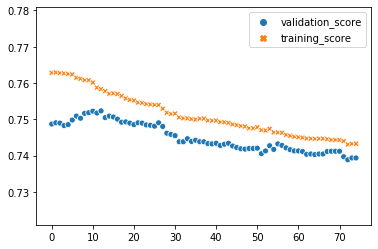

In [298]:
# Parameter tuning (small sample only on baby laptop, <2000 observations)
model_evals = []
for num_leaves in range(50,125):
    pipeline = make_pipeline(
                        DecisionTreeClassifier(min_samples_leaf=num_leaves, random_state=42)
                        )
    pipeline.fit(X_train, y_train)
    model_evals.append([pipeline.score(X_val, y_val), pipeline.score(X_train, y_train)])

model_evals = pd.DataFrame(model_evals, columns=['validation_score', 'training_score'])
sns.scatterplot(data=model_evals)

In [308]:
# Single pass run (optimum min_samples_leaf)
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

num_leaves = 62
pipeline = make_pipeline(
                        DecisionTreeClassifier(min_samples_leaf=num_leaves, random_state=42)
                        )

pipeline.fit(X_train, y_train)
print('Training Accuracy: ', pipeline.score(X_train, y_train))
print('Validation Accuracy: ', pipeline.score(X_val, y_val))

Training Accuracy:  0.7583492918622025
Validation Accuracy:  0.7523569023569023


C:\Users\vince\Anaconda3\envs\datasc\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\vince\Anaconda3\envs\datasc\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\vince\Anaconda3\envs\datasc\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\vince\Anaconda3\envs\datasc\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\vince\Anaconda3\envs\datasc\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarni

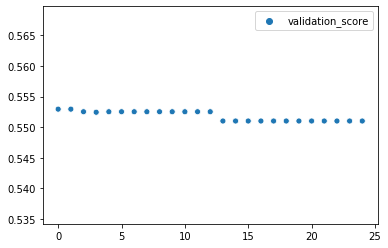

In [311]:
# Test against linear regression
# Feature selection via SelectKBeset
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

model_evals = []
model = LogisticRegression(solver='saga', multi_class='auto',max_iter=1000, n_jobs=3)

for k in range(60, 85):#len(X_train.columns.values)):
    selector = SelectKBest(chi2, k=k).fit(X_train, y_train)
    X_train_new = selector.transform(X_train)
    X_val_new = selector.transform(X_val)
    
    model.fit(X_train_new, y_train)
    model_evals.append(model.score(X_val_new, y_val))
    
model_evals = pd.DataFrame(model_evals, columns=['validation_score'])
sns.scatterplot(data=model_evals)

**Seeing a 20% regression over previous efforts in logistic regression using this X_train, y_train transformed via pipeline.  More debugging may be necessary to make sure the data transforms are working properly.  Change of scalar type seems to impact logistic regression a lot when outliers present.**

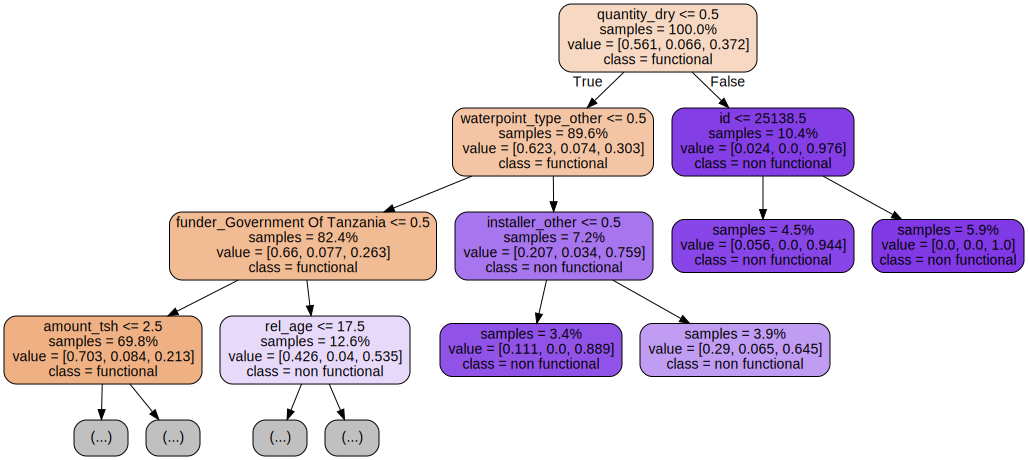

In [77]:
# Plot feature importance (decision-tree)
from IPython.display import display, HTML
import graphviz
from sklearn.tree import export_graphviz

max_depth = 3

display(HTML(f'Max Depth {max_depth}'))
display(HTML(f'Train Accuracy {pipeline.score(X_train, y_train):.2f}'))
display(HTML(f'Validation Accuracy {pipeline.score(X_val, y_val):.2f}'))

# Plot tree
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
import os, sys
in_colab = 'google.colab' in sys.modules
if not in_colab:
    os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

dot_data = export_graphviz(pipeline.named_steps['decisiontreeclassifier'], 
                           out_file=None, 
                           max_depth=3, 
                           feature_names=X_train.columns,
                           class_names=pipeline.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))

In [ ]:
# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-02.csv', index=False)